# Chapter 6. Deploying your API to the Cloud

It sounds a little extreme, but in this day and age, if your work isn’t online, it doesn’t exist.

Austin Kleon, Show Your Work! 10 Ways to Share Your Creativity and Get Discovered (Workman, 2014)

You have made great progress with your first API. You have selected the most important qualities for your users, developed multiple API endpoints, and created user-friendly documentation. In this chapter, you will publish your API to the cloud, where consumers can access it. This is another chance to share what you have been working on.

https://ryandaydev.medium.com/using-apis-with-ai-tell-me-all-the-ways-3f81fb06eca9

This chapter includes instructions for deploying to two cloud hosts, and I would encourage you to try out both of them to see the advantages and disadvantages of each. You will begin by using Render, which is fairly simple to deploy. Then, you will install and configure the Docker containerization tool, which you will use to deploy to Amazon Web Services (AWS).

| Software or service name | Version | Purpose |
| :--- | :---: | :--- |
| `Amazon Lightsail` | `NA` | AWS virtual cloud server |
| `AWS CLI` | `2.15` | Command-line interface for AWS services |
| `Docker` | `24.0` | Pack and run your application in a container |
| `Render` | `NA` | Cloud hosting provider |

# Deploying to Render

Render calls itself "a unified cloud to build and run all your apps and websites."

c7r5iklh

At the time of this writing, Render has a pricing plan that includes Python hosting for free, execept for a small cost for monthly storage. You will be generally following the instuctions from [Deploy a FastAPI App](https://oreil.ly/nmdaK)

The process of deploying to Render only involves a few steps, as shown here:

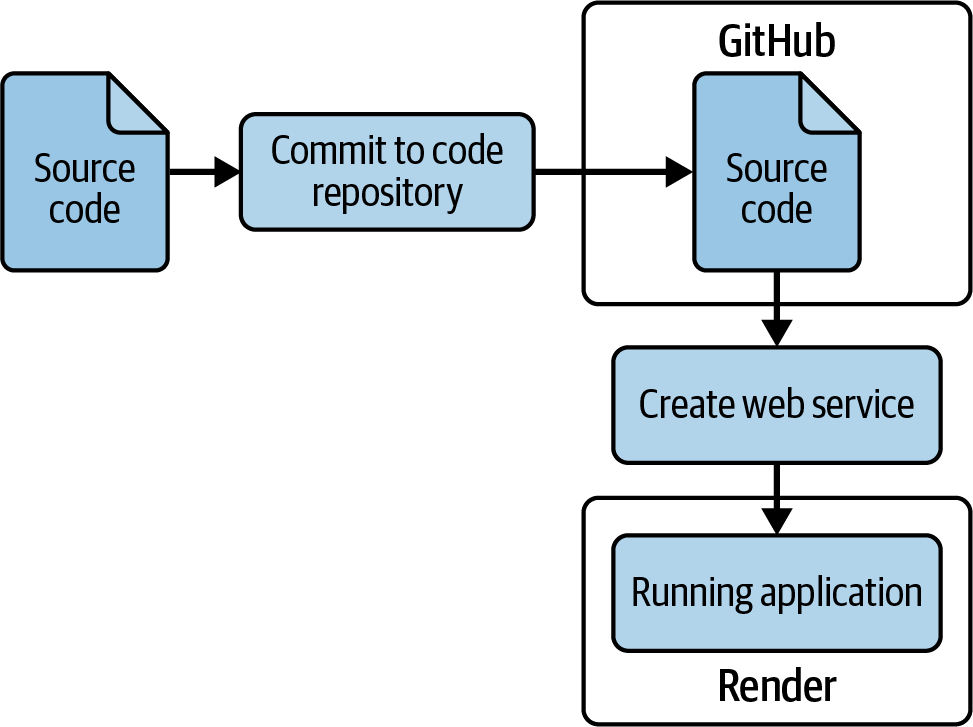

# Shipping Your Application in a Docker Container

Whereas Render deployed your application from a source code repository (GitHub), AWS will use an application named Docker. Docker is a very useful tool for shipping applications in containers. Just as cargo is shipped in a shipping container, applications are shipped in a software container.

The Docker glossary explains a few key terms that you will use. A Dockerfile is “a text document that contains all the commands you would normally execute manually to build a Docker image.” The container image, or Docker image, is “an ordered collection of root filesystem changes and the corresponding execution parameters for use within a container runtime.” A repository is a set of Docker images. A container runtime is software that uses the image to create a container, which is a runtime instance of a container image. You will use Docker as your container runtime.

The Docker glossary explains a few key terms that you will use. A Dockerfile is “a text document that contains all the commands you would normally execute manually to build a Docker image.” The container image, or Docker image, is “an ordered collection of root filesystem changes and the corresponding execution parameters for use within a container runtime.” A repository is a set of Docker images. A container runtime is software that uses the image to create a container, which is a runtime instance of a container image. You will use Docker as your container runtime.

| Command | Purpose |
| :--- | :--- |
| `docker --version` | Verify what version of the library is installed. |
| `docker build -t` | Build an image from a Dockerfile. |
| `docker images` | List local images in your environment. |
| `docker run` | Run a container from a local image. |

You will perform a couple of fairly simple steps.

* Create a Dockerfile
* Build a container image from this Dockefile
* Run a container based on this image.

# Creating a Dockerfile

A _Dockerfile_ contains the instructions that Docker will use to create a container image. Keep in mind that the statements will be executed in the `docker build` step that you will initiate. Create a file named `chapter6/Dockerfile`.

use uv instead of pip, here is chapter6/Dockerfileuv:

```
# Start with the slim parent image
FROM python:3.13-slim

# 1. Install uv
# The official recommendation is to copy the binary from the astral-sh image
COPY --from=ghcr.io/astral-sh/uv:latest /uv /uvx /bin/

# Set the Docker working directory
WORKDIR /code

# 2. Copy the project definition files first
# We copy these alone first to leverage Docker layer caching.
# If your code changes but dependencies don't, Docker skips the install step on rebuilds.
COPY pyproject.toml uv.lock /code/

# 3. Install dependencies
# --frozen: strict install from uv.lock (fails if lock file is out of sync)
# --no-cache: keeps the image size small
RUN uv sync --frozen --no-cache

# 4. Update PATH environment variable
# uv sync installs into a virtual environment at /code/.venv by default.
# We must add this to the PATH so the system finds 'uvicorn' automatically.
ENV PATH="/code/.venv/bin:$PATH"

# Copy the code files and database from the build context directory
COPY *.py /code/
COPY *.db /code/

# Launch the Uvicorn web server
# Because of the PATH command above, this runs the uvicorn inside the .venv
CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "80"]
```

You are absolutely right. Good catch.

Your `pyproject.toml` explicitly demands Python 3.13 or newer (`requires-python = ">=3.13"`). If you try to run `uv sync` inside a `python:3.10` container, `uv` will error out because the environment doesn't meet the project's requirements.

You simply need to change the base image tag to match your requirement.

### Updated Dockerfile (Fixed Python Version)

```dockerfile
# CHANGE: Updated from 3.10-slim to 3.13-slim to match pyproject.toml
FROM python:3.13-slim

# Install uv
COPY --from=ghcr.io/astral-sh/uv:latest /uv /uvx /bin/

# Set the Docker working directory
WORKDIR /code

# Copy the project definition files
COPY pyproject.toml uv.lock /code/

# Install dependencies
RUN uv sync --frozen --no-cache

# Update PATH so the system finds the .venv executable
ENV PATH="/code/.venv/bin:$PATH"

# Copy the code files and database
COPY *.py /code/
COPY *.db /code/

# Launch the application
CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "80"]
```

### A note on your dependencies

I noticed your `pyproject.toml` includes **`jupyter`** and **`scipy`** in the main `dependencies` list (rather than in `dev` or a separate group).

  * **Impact:** This will make your Docker image significantly larger because it installs the entire Jupyter Lab interface and SciPy's heavy binaries into your API container, even though the `CMD` only runs `uvicorn`.
  * **For now:** Since you are following a textbook, stick with this to ensure all the code examples in the book work as intended.
  * **For the future:** In a "real" production API, you would typically move `jupyter`, `lab`, and `jupytext` to the `[dependency-groups] dev` section so your production image stays lightweight.

**Next Step:** You are copying a SQLite database (`*.db`) into the image. If your app writes to this database, those changes will disappear if the container stops. Would you like me to explain how to use a **Docker Volume** to make your data persist?

Just like .gitignore excludes files from version control, you want to exclude some files in your directory from the Docker image. Create a file named .dockerignore with the following contents:

```
# This is the .dockerignore file for Chapter 6
.gitignore

readme.md

*.DS_Store/

**/__pycache__
```

# Building a Container Image

To put this Dockefile to use, enter the following command at the command line:

```bash
.../chapter6 (main) $ docker build -t apicontainerimage
```

Yes, you are exactly right. By default, Docker looks for a file named simply `Dockerfile`.

To tell Docker to use a specific file with a different name (like `Dockerfileuv`), you need to use the **`-f`** (file) flag.

Here is the command you need to run:

```bash
docker build -f Dockerfileuv -t apicontainerimage .
```

### Breakdown of the command:

  * **`-f Dockerfileuv`**: Explicitly tells Docker, "Use the file named `Dockerfileuv` instead of the default."
  * **`-t apicontainerimage`**: Tags (names) the image `apicontainerimage`.
  * **`.` (The Dot)**: **Crucial\!** This tells Docker to look for the files (context) in the **current directory**. Do not forget this dot at the end, or the command will fail.

### A suggestion for your testing

Since you are keeping both files to compare them, you might want to give this image a specific tag so you don't confuse it with the book's version later:

```bash
docker build -f Dockerfileuv -t apicontainerimage:uv .
```

This way:

1.  `apicontainerimage:latest` (or just `apicontainerimage`) could be the book's version.
2.  `apicontainerimage:uv` is your custom `uv` version.

**Next Step:** Once it builds successfully, would you like to know the command to "exec" (login) into the running container so you can verify that `uv` installed the libraries correctly?

```bash
docker build -f Dockerfileuv -t apicontainerimage:uv .
```

This tells Docker to build an image (apicontainerimage) using the Dockerfile in the current directory. The container image will be stored in your local Docker repository.

You should see multiple steps being executed. The first time you run this command, this may take several minutes. Future builds will take less time because Docker can cache items that do not change. You should see something similar to the following when it is completed:

```
 => [stage-0 7/7] COPY *.db /code/                                    0.1s
 => exporting to image                                                1.4s
 => => exporting layers                                               1.3s
 => => writing image sha256:f3b3b4206e476362cc7a8569cc401fbf54ee559e  0.0s
 => => naming to docker.io/library/apicontainerimage:uv               0.0s
(api-book-part-one) davidd@DellXPSDavidD:~/2025/api-book-part-one/chapter6$
```

To verify that the image was created successfully, enter the command docker images to view the images in your repository. You should see something like the following:

```bash
docker images
```

Yes, that looks **perfect**.

That specific line (`naming to ...`) is the final "success" stamp from Docker. It means:

1.  All the steps in your `Dockerfileuv` executed without error.
2.  Docker successfully saved the resulting image.
3.  It applied the specific tag **`:uv`** that we discussed.

### How to verify

You can now run the command from the very first table you asked for to see it in your list:

```bash
docker images
```

You should see `apicontainerimage` with the TAG `uv`.

**Next Step:** Since you built this with a custom tag, remember that when you run it, you must specify that tag. Would you like the full `docker run` command to launch this specific `uv` version of your container?

# Running Your Container Image Locally

You use the docker run command to run a container based on this image. There are just a couple of options to notice here. The statement --publish 80:80 maps port 80 inside the Docker container (the second 80) to port 80 on your local environment (the first 80). The statement --name apicontainer1 sets the name of the container that you will be using. This is a convenient way to reference the running container (Docker will also assign an image ID). Finally, apicontainerimage passes the image name that you built in the previous step. Remember, the image is used to run a container.

Execute the following command:

.../chapter6 (main) $ docker run --publish 80:80 --name apicontainer1
apicontainerimage+

(api-book-part-one) davidd@DellXPSDavidD:~/2025/api-book-part-one/chapter6$ docker images
REPOSITORY                                                     TAG         IMAGE ID       CREATED          SIZE
apicontainerimage                                              uv          f3b3b4206e47   19 minutes ago   696MB

Success\! You have successfully built your custom `uv` image. (696MB is a bit large, as we suspected due to the extra Jupyter/SciPy dependencies, but it is ready to go).

Here is the command to run it.

### The Command

```bash
docker run --rm -p 8000:80 apicontainerimage:uv
```

### Breakdown of the flags:

  * **`--rm`**: Automatically removes the container when you stop it. This keeps your machine clean so you don't end up with dozens of stopped containers cluttering your drive.
  * **`-p 8000:80`**: This is the **Port Mapping**.
      * The **first number (8000)** is the port on your *local machine* (host).
      * The **second number (80)** is the port inside the *container* (which we set in the Dockerfile with `--port 80`).
      * *Result:* You will access the app at `http://localhost:8000`.
  * **`apicontainerimage:uv`**: Tells Docker to use your specific `uv` version, not the standard one.

### How to stop it

Since we are running this in the foreground so you can see the logs, you can stop it by pressing:
**`Ctrl + C`**

**Next Step:** Once it is running, would you like to verify it is working by using `curl` from a new terminal window, or do you prefer to test it in your web browser?

That is a great question. The differences come down to **safety** and **avoiding errors**.

Here is the breakdown of why my suggested command differs from the book's command.

### 1\. The Ports (`-p 8000:80` vs `80:80`)

The syntax for publishing ports is always **`HOST_PORT : CONTAINER_PORT`**.

  * **Right side (80):** This **must** be 80. Your `Dockerfile` (and the book's) ends with `--port 80`. The container is listening inside on port 80.
  * **Left side (Host Port):** This is the port you use in your browser.
      * **The Book (`80`):** Uses the standard HTTP port. This means you can type `http://localhost` without a port number.
      * **My Suggestion (`8000`):** Uses a "high" port.
      * **The Risk with Port 80:** On many systems (Linux, Mac, and sometimes Windows/WSL), port 80 is a **privileged port**. If you try to run the book's command, you might get a `Permission denied` error unless you use `sudo`, or it might clash with a system service already running on port 80.

### 2\. The Cleanup (`--rm` vs `--name`)

  * **The Book (`--name apicontainer1`):** Giving it a static name is useful if you want to stop and restart it later using that specific name.
      * *The Trap:* If you stop this container and try to run the `docker run` command again, Docker will yell at you: `Error: The name "apicontainer1" is already in use.` You have to manually `docker rm` the old one before running it again.
  * **My Suggestion (`--rm`):** This tells Docker, "As soon as I stop this container (Ctrl+C), delete it." This is usually better for learning/debugging because it keeps your environment clean.

### Summary Recommendation

Since you are on a Dell XPS (likely running WSL or Windows), port 80 might work, but port 8000 is safer.

**If you want to stick as close to the book as possible** but use your custom `uv` image, run this:

```bash
docker run --publish 80:80 --name apicontainer1 apicontainerimage:uv
```

*(Note: If you get a "permission denied" or "port already allocated" error, switch the first `80` to `8000`\!)*

**Next Step:** Are you ready to try sending a request to your API now that we know how to launch it?

This is a classic "Docker vs. Host" confusion, and it happens to almost everyone their first time.

You are seeing `ERR_ADDRESS_INVALID` because of two small mismatches between what the **Container** sees and what your **Browser** sees.

### 1\. The Address Mismatch (`0.0.0.0`)

  * **Inside the container:** `0.0.0.0` means "I am listening for connections from anywhere." It is a setting, not a web address.
  * **In your browser:** `0.0.0.0` is not a valid address you can visit (especially on Windows). You need to use **`localhost`** (or `127.0.0.1`) which means "my current computer."

### 2\. The Port Mismatch (`8000` vs `80`)

Look at your command:
`docker run ... -p 8000:80 ...`

  * The **second** number (80) is where the app lives **inside** the box.
  * The **first** number (8000) is the "door" you opened on the **outside**.

Your browser is on the **outside**, so it must use port **8000**.

### The Correct URL

Try this link instead:

**[http://localhost:8000](https://www.google.com/search?q=http://localhost:8000)**

Since this is FastAPI, you can also see the automatic documentation page here (which confirms everything is working perfectly):

**[http://localhost:8000/docs](https://www.google.com/search?q=http://localhost:8000/docs)**

**Next Step:** Once you confirm that loads, would you like me to show you how to use `curl` to send a specific piece of data to your API to test it without the browser?

Congratulations! Your application is being run by Docker in a container that you defined. To stop the application, press Ctrl-C.

# Deploying to AWS

The AWS deployment will take advantage of the Docker container that you created. You will run your application using the Amazon Lightsail service, which is one of the simpler AWS services to get started with. 

To begin, [create a new AWS account](https://oreil.ly/09mZ7) and store your login credentials securely. For this project, it will be acceptable to use the _root user_ account, which is the full owner of the account identified by the email address. However, you should enable multifactor authentication (MFA), following the directions [in the AWS Identify and Access Management User Guide](https://oreil.ly/N5Q7e)

In [ ]:

downloaded = "admin-user_accessKeys.csv"

In [4]:
import pandas as pd
dfacces = pd.read_csv(downloaded)
#dfacces.head()

In [5]:
creds = "admin-user_credentials.csv"
dfcreds = pd.read_csv(creds)
#dfcreds.head()

Based on the documentation you provided, the best way to handle this—since you already have work credentials configured—is to use what the guide calls **"Command line options"** and **"Configuration and credential precedence"**.

The documentation lists **"IAM user long-term credentials"** as an option. While it is marked "Not recommended" for enterprise security, it is the standard method used by almost every textbook and tutorial because it is stable and simple to set up.

Here is how to set up your personal credentials safely **without** overwriting your work configuration.

### Step 1: Create the Keys (In the Browser)

Since you have a new personal AWS account, you need to generate the keys first.

1.  Log in to your **Personal** AWS Console.
2.  Search for **IAM** and click **Users**.
3.  Create a user (e.g., `admin-user`) and attach the `AdministratorAccess` policy (for learning purposes).
4.  Go to the **Security credentials** tab for that user.
5.  Scroll to **Access keys** and click **Create access key**.
6.  Select **Command Line Interface (CLI)**, acknowledge the warning, and click **Next**.
7.  **Copy** the `Access Key ID` and `Secret Access Key` (or download the .csv).

### Step 2: Configure a "Named Profile" (In the Terminal)

To avoid breaking your work setup, we will create a specific **Profile**. The documentation notes that the config file is located at `~/.aws/config`, and using a profile adds a new section to this file rather than overwriting the `[default]` one.

Run this command in your terminal:

```bash
aws configure --profile personal
```

It will prompt you for four items. Paste the details from Step 1:

1.  **AWS Access Key ID:** `[Paste your new Personal Key ID]`
2.  **AWS Secret Access Key:** `[Paste your new Personal Secret Key]`
3.  **Default region name:** `us-east-1` (Or `us-west-2`; check your book, but `us-east-1` is the safest default).
4.  **Default output format:** `json`

### Step 3: Verify the Setup

To confirm you are using the correct account, run this command using the new profile flag:

```bash
aws sts get-caller-identity --profile personal
```

You should see your **personal** account ID, not your work one.

### How to use this going forward

Because you saved this as a profile, you have two options for the rest of your textbook:

**Option A: Add the flag to every command (Safe)**

```bash
aws lightsail get-container-services --profile personal
```

**Option B: Set an Environment Variable (Convenient)**
The documentation states that **"Environment variables"** take precedence over the config file. You can switch your entire terminal session to "personal mode" by running:

```bash
export AWS_PROFILE=personal
```

Now, every `aws` command (and the `lightsailctl` plugin) will automatically use your personal credentials until you close that terminal window.

**Next Step:** Now that your credentials are set, do you want to proceed with the command to actually push your Docker container to Lightsail?

# Pushing Your Container Image to Lightsail

Next, you will use the AWS CLI to push a container image to Lightsail. If you run into any issues during these instructions, additional information is available at [Push, view, and delete container images for a Lightsail container service page](https://oreil.ly/lJ0wX)

To verify that your docker images are still in your local repository where you build them in the previous sections of this chapter, enter the following:

```bash
docker images
```

```bash
(api-book-part-one) davidd@DellXPSDavidD:~/2025/api-book-part-one/chapter6$ aws lightsail get-container-services --region us-west-2 --profile personal
{
    "containerServices": [
        {
            "containerServiceName": "aws-api-container",
            "arn": "arn:aws:lightsail:us-west-2:890172404445:ContainerService/302afad6-4f2b-473b-9ef5-aaa410ba2103",
            "createdAt": "2025-12-08T08:38:35-07:00",
            "location": {
                "availabilityZone": "all",
                "regionName": "us-west-2"
            },
            "resourceType": "ContainerService",
            "tags": [],
            "power": "micro",
            "powerId": "micro-1",
            "state": "READY",
            "scale": 1,
            "isDisabled": false,
:
```

Success\! That output confirms everything is perfect:

1.  **Access Granted:** Your `admin-user` credentials are working.
2.  **Service Ready:** The service `aws-api-container` exists and is in the `READY` state.

You are now cleared to push your custom image.

### The Command to Push

Run this command again (it should work this time):

```bash
aws lightsail push-container-image --region us-west-2 --service-name aws-api-container --label aws-api --image apicontainerimage:uv --profile personal
```

### What to Expect

  * You will see a progress bar or a "Pushed" message for each layer of your Docker image.
  * Since your image is **696MB**, this might take a minute or two depending on your upload speed.
  * **Success Message:** When it finishes, look for a line at the bottom that says:
    `Refer to this image as ":aws-api-container.aws-api.1"`

**Next Step:** While that uploads, would you like me to prepare the JSON command you will need for the final step (Deploying the container to the public internet)?

Great\! The push was successful.

The key piece of information from that output is the **Image Reference**:

> `Refer to this image as ":aws-api-container.aws-api.1"`

You now need to tell Lightsail to actually **run** this image and open it to the public.

Here is the exact command to create the deployment. I have configured it to:

1.  Use the image you just pushed (`:aws-api-container.aws-api.1`).
2.  Open **Port 80** (which matches your Dockerfile).
3.  Set the **Public Endpoint** so you can access it from the internet.

### The Deployment Command

Copy and paste this entire block into your terminal:

```bash
aws lightsail create-container-service-deployment \
--service-name aws-api-container \
--containers '{
    "my-api-container": {
        "image": ":aws-api-container.aws-api.1",
        "ports": {
            "80": "HTTP"
        }
    }
}' \
--public-endpoint '{"containerName": "my-api-container", "containerPort": 80, "healthCheck": {"path": "/docs"}}' \
--region us-west-2 \
--profile personal
```

### What this does:

  * **`--containers`**: This JSON block defines the "pod" setup. We are naming the internal container `my-api-container` and telling it to use the image you just uploaded.
  * **`--public-endpoint`**: This connects the internet to your container. It routes traffic from the public URL to port 80 of `my-api-container`.
  * **`healthCheck`**: I added a check on `/docs`. Lightsail will ping this to make sure your app is actually running before sending traffic to it.

**Next Step:** After you run this, it will take a few minutes to change from `DEPLOYING` to `RUNNING`. Would you like the command to watch the status so you know when it is live?

```bash
watch -n 5 "aws lightsail get-container-services --service-name aws-api-container --region us-west-2 --profile personal"
```

```bash
aws lightsail get-container-services \
    --service-name aws-api-container \
    --region us-west-2 \
    --profile personal \
    --query "containerServices[0].url" \
    --output text
```

https://aws-api-container.xnkp6vj8k4sar.us-west-2.cs.amazonlightsail.com/

That is a huge win\! You have successfully built a custom Python image using `uv`, pushed it to the cloud, and deployed it to a public endpoint.

Since this is a paid service (even though it's cheap, about $7/month if left running), it is good practice to shut it down when you are done testing so you don't get a surprise bill.

### 1\. The Command to Delete the Service

This will completely remove the container service and the public URL.

```bash
aws lightsail delete-container-service --service-name aws-api-container --region us-west-2 --profile personal
```

### 2\. Verification

To double-check that it is actually gone, run the "list" command one last time. You should get an empty list `[]` (or an error saying the service doesn't exist).

```bash
aws lightsail get-container-services --region us-west-2 --profile personal
```

### Summary of what you just accomplished:

1.  **Modernized the stack:** You swapped standard `pip` for `uv` in a Docker environment.
2.  **Fixed Permissions:** You navigated IAM policies to grant your new user the right access.
3.  **Deployed to Cloud:** You took code from your local machine and made it accessible to the entire world via AWS Lightsail.

**Next Step:** Now that you've finished the "Hello World" of cloud deployment, does the book move on to connecting this API to a real database (like RDS), or does it get into CI/CD pipelines next?